In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("clms.txt", header=None)
df["x"] = df[0]

# Part 1

## (a):


In [94]:
print("\nMean: {}".format(np.mean(df["x"])))
print("\nMedian: {}".format(np.median(df["x"])))
print("\nMaximum: {}".format(np.max(df["x"])))
print("\nMinimum: {}".format(np.min(df["x"])))
print("\nStandard Deviation: {}".format(np.std(df["x"])))


Mean: 720.2779753272415

Median: 172.21

Maximum: 227967.25

Minimum: 0.01

Standard Deviation: 3972.663756393654


Text(0, 0.5, 'Number of observations')

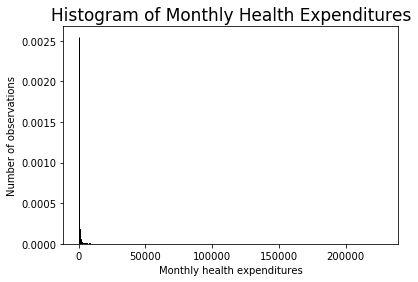

In [158]:
# Plot histogram
num_bins = 1000
count, bins, ignored = plt.hist(df.x, num_bins, density=True,
                                edgecolor='k')
plt.title('Histogram of Monthly Health Expenditures', fontsize=17)
plt.xlabel(r'Monthly health expenditures')
plt.ylabel(r'Number of observations')

Text(0, 0.5, 'Number of observations')

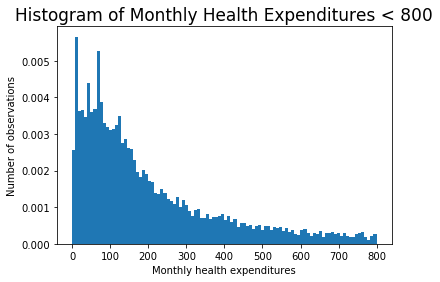

In [128]:
`

Monthly health expenditures have a positively skewed distribution with a really long tail of outliers. From the first figure we can see that even with a thousand bins, we find that the a single bin captures almost 0.6 of the observations. It just doesn't let us visualize the distribution the data very well. Truncating the data at 800 is one way of skirting around this outlier problem.

## (b)

In [668]:
import math 
import scipy.optimize as opt

initial_beta0 = np.var(df["x"])/np.mean(df["x"])
initial_alpha0 = np.mean(df["x"])/initial_beta0

def crit_ga(params, *args):
    beta_value, alpha_value = params
    df = list(args)[0]
    df["pdf_values"] = 1/(beta_value**(alpha_value) * math.gamma(alpha_value))*df.x**(alpha_value-1)*np.exp(-df.x/beta_value)
    df.loc[df["pdf_values"] < 1e-7, "pdf_values"] = 1e-7
    negloglik = -sum(np.log(df["pdf_values"]))
    return negloglik

params_init = np.array([initial_beta0, initial_alpha0])
mle_args = (df)
results_uncstr = opt.minimize(crit_ga, params_init, args=(mle_args),  
                              method='TNC',
                 bounds=((1e-10, None), (1e-10, None)), tol=1e-12,options={'maxiter':1000}
                             )

beta_MLE, alpha_MLE = results_uncstr.x

In [669]:
results_uncstr

     fun: 76003.27448839728
     jac: array([0.06693881, 0.04656613])
 message: 'Converged (|f_n-f_(n-1)| ~= 0)'
    nfev: 168
     nit: 19
  status: 1
 success: True
       x: array([551.01795008,   0.7102143 ])

In [670]:
print("beta_hat = {}".format(beta_MLE))
print("alpha_hat = {}".format(alpha_MLE))
log_like_ga = -1*crit_xy((beta_MLE, alpha_MLE), df.x)
print("Maximized log likelihood = {}".format(log_like_ga))

beta_hat = 551.0179500811464
alpha_hat = 0.7102143006296369
Maximized log likelihood = -80195.97107411947


In [671]:
def ga_pdf_plotting(x_values, beta_value, alpha_value):
    df = pd.DataFrame({'x':x_values})
    df["pdf_values"] = 1/(beta_value**(alpha_value) * math.gamma(alpha_value))*x_values**(alpha_value-1)*np.exp(-x_values/beta_value)
    df.loc[df["pdf_values"] < 1e-8, "pdf_values"] = 1e-8
    return df["pdf_values"].tolist()

/Users/xiangyu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in power
  This is separate from the ipykernel package so we can avoid doing imports until


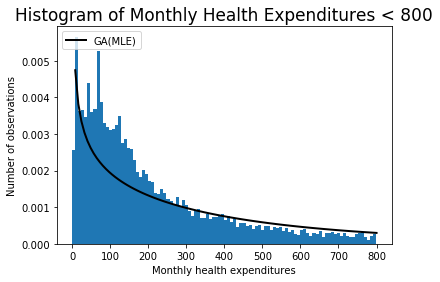

In [672]:
# Plot histogram
df2 = df.loc[df["x"]<= 800,:]
num_bins = 100
count, bins, ignored = plt.hist(df2.x, num_bins, density=True)
plt.title('Histogram of Monthly Health Expenditures < 800', fontsize=17)
plt.xlabel(r'Monthly health expenditures')
plt.ylabel(r'Number of observations')
dist_pts = np.linspace(0, 800, 100)
plt.plot(dist_pts, ga_pdf_plotting(dist_pts, beta_MLE, alpha_MLE),
         linewidth=2, color='k', label='GA(MLE)')
plt.legend(loc='upper left')

## (c):

In [673]:
def gg_pdf(df, beta_v, alpha_v, m_v):
    df["pdf_values"] = m_v/(beta_v**alpha_v*math.gamma(alpha_v/m_v))*df.x**(alpha_v-1)*np.exp(-1*(df.x/beta_v)**m_v)
    df.loc[df["pdf_values"] < 1e-7, "pdf_values"] = 1e-7
    return df["pdf_values"]

def crit_gg(params, *args):
    beta_value, alpha_value, m_value = params
    df = list(args)[0]
    df_loglik = np.log(gg_pdf(df, beta_value, alpha_value, m_value))
    negloglik = -sum(df_loglik)
    return negloglik    

In [674]:
params_init = np.array([beta_MLE, alpha_MLE, 1])
mle_args = (df)
results_uncstr_gg = opt.minimize(crit_gg, params_init, args=(mle_args),  
                                 method='TNC',
                 bounds=((0.01, None), (0.010, None), (0.01, None)), tol=1e-3, 
                                 options={'maxiter':1000})

In [675]:
results_uncstr_gg

     fun: 75870.65476733548
     jac: array([  1.03900675,  13.08799256, -10.46719262])
 message: 'Converged (|f_n-f_(n-1)| ~= 0)'
    nfev: 47
     nit: 5
  status: 1
 success: True
       x: array([550.42120955,   0.66531823,   0.82996082])

In [676]:
beta_MLE_gg, alpha_MLE_gg, m_MLE_gg = results_uncstr_gg.x

In [677]:
print("beta_hat using the GG distr. = {}".format(beta_MLE_gg))
print("alpha_hat using the GG distr. = {}".format(alpha_MLE_gg))
print("m_hat using the GG distr. = {}".format(m_MLE_gg))
log_lik_gg = sum(np.log(gg_pdf(df, beta_MLE_gg, alpha_MLE_gg, m_MLE_gg)))
print("Maximized log likelihood = {}".format(log_lik_gg))

beta_hat using the GG distr. = 550.4212095517073
alpha_hat using the GG distr. = 0.6653182311482059
m_hat using the GG distr. = 0.8299608225897052
Maximized log likelihood = -75870.65476733548


In [678]:
def gg_pdf_plotting(df, beta_v, alpha_v, m_v):
    df = pd.DataFrame({'x':df})
    df["pdf_values"] = m_v/(beta_v**alpha_v*math.gamma(alpha_v/m_v))*df.x**(alpha_v-1)*np.exp(-1*(df.x/beta_v)**m_v)
    df.loc[df["pdf_values"] < 1e-8, "pdf_values"] = 1e-8
    return df["pdf_values"].tolist()



/Users/xiangyu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in power
  This is separate from the ipykernel package so we can avoid doing imports until


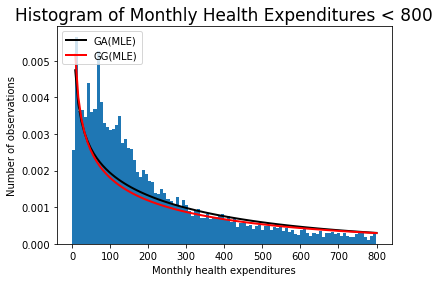

In [679]:
# Plot histogram
df2 = df.loc[df["x"]<= 800,:]
num_bins = 100
count, bins, ignored = plt.hist(df2.x, num_bins, density=True)
plt.title('Histogram of Monthly Health Expenditures < 800', fontsize=17)
plt.xlabel(r'Monthly health expenditures')
plt.ylabel(r'Number of observations')
dist_pts = np.linspace(0, 800, 100)
plt.plot(dist_pts, ga_pdf_plotting(dist_pts, beta_MLE, alpha_MLE),
         linewidth=2, color='k', label='GA(MLE)')
plt.legend(loc='upper left')
plt.plot(dist_pts, gg_pdf_plotting(dist_pts, beta_MLE_gg, alpha_MLE_gg, m_MLE_gg),
         linewidth=2, color='r', label='GG(MLE)')
plt.legend(loc='upper left')

## (d)

In [680]:
from scipy.special import beta

In [681]:
df = pd.read_csv("clms.txt", header=None)
df["x"] = df[0]

In [687]:
def gb2_pdf(df, a_value, b_value, p_value, q_value):
    df["pdf_values"] = a_value*df.x**(a_value*p_value-1)/b_value**(a_value*p_value)/beta(p_value, q_value)/(1+(df.x/b_value)**a_value)**(p_value+ q_value)
    df.loc[df["pdf_values"] < 1e-12, "pdf_values"] = 1e-12
    return df["pdf_values"]

def crit_gb2(params, *args):
    a_value, b_value, p_value, q_value = params
    df = list(args)[0]
    df_loglik = np.log(gb2_pdf(df, a_value, b_value, p_value, q_value))
    negloglik = -sum(df_loglik)
    return negloglik

In [688]:
q_value_init =10000
a_value_init = m_MLE_gg
b_value_init = q_value_init**(1/m_MLE_gg)*beta_MLE_gg
p_value_init = alpha_MLE_gg/m_MLE_gg
params_init =  np.array([a_value_init, b_value_init, p_value_init, q_value_init])
mle_args = (df)

In [689]:
results_uncstr_gb2 = opt.minimize(crit_gb2, params_init, args=(mle_args),  
                                  method='TNC',
                 bounds=((1e-8, None), (1e-8, None), (1e-8, None), (1e-8, None)), tol=1e-10, options={'maxiter':3000})

In [690]:
results_uncstr_gb2

     fun: 76717.34962536838
     jac: array([2.01150106e+03, 1.45519152e-03, 5.59962064e+02, 4.71307430e+01])
 message: 'Converged (|x_n-x_(n-1)| ~= 0)'
    nfev: 127
     nit: 5
  status: 2
 success: True
       x: array([8.37046411e-01, 3.63245094e+07, 8.01353570e-01, 9.87142069e+03])

In [691]:
a_MLE_gb2, b_MLE_gb2, p_MLE_gb2, q_MLE_gb2 = results_uncstr_gb2.x

In [697]:
print("a_hat using the GB2 distr. = {}".format(a_MLE_gb2))
print("b_hat using the GB2 distr. = {}".format(b_MLE_gb2))
print("p_hat using the GB2 distr. = {}".format(p_MLE_gb2))
print("q_hat using the GB2 distr. = {}".format(q_MLE_gb2))
loglik_gb2 = sum(np.log(gb2_pdf(df, a_MLE_gb2, b_MLE_gb2, p_MLE_gb2, q_MLE_gb2)))
print("Maximized log likelihood = {}".format(loglik_gb2))

a_hat using the GB2 distr. = 0.8370464113216801
b_hat using the GB2 distr. = 36324509.41502439
p_hat using the GB2 distr. = 0.8013535696450651
q_hat using the GB2 distr. = 9871.420693943379
Maximized log likelihood = -76717.34962536838


In [693]:
def gb2_pdf_plotting(df, a_value, b_value, p_value, q_value):
    df = pd.DataFrame({'x':df})
    df["pdf_values"] = a_value*df.x**(a_value*p_value-1)/b_value**(a_value*p_value)/beta(p_value, q_value)/(1+(df.x/b_value)**a_value)**(p_value+ q_value)
    df.loc[df["pdf_values"] < 1e-8, "pdf_values"] = 1e-8
    return df["pdf_values"].tolist()

/Users/xiangyu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in power
  This is separate from the ipykernel package so we can avoid doing imports until


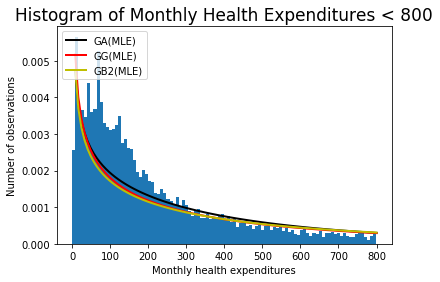

In [694]:
# Plot histogram
df2 = df.loc[df["x"]<= 800,:]
num_bins = 100
count, bins, ignored = plt.hist(df2.x, num_bins, density=True)
plt.title('Histogram of Monthly Health Expenditures < 800', fontsize=17)
plt.xlabel(r'Monthly health expenditures')
plt.ylabel(r'Number of observations')
dist_pts = np.linspace(0, 800, 100)
plt.plot(dist_pts, ga_pdf_plotting(dist_pts, beta_MLE, alpha_MLE),
         linewidth=2, color='k', label='GA(MLE)')
plt.legend(loc='upper left')
plt.plot(dist_pts, gg_pdf_plotting(dist_pts, beta_MLE_gg, alpha_MLE_gg, m_MLE_gg),
         linewidth=2, color='r', label='GG(MLE)')
plt.legend(loc='upper left')
plt.plot(dist_pts, gb2_pdf_plotting(dist_pts, a_MLE_gb2, b_MLE_gb2, p_MLE_gb2, q_MLE_gb2),
         linewidth=2, color='y', label='GB2(MLE)')
plt.legend(loc='upper left')


## (e)

In [568]:
import scipy.stats as sts

In [701]:
loglik_gb2 - log_lik_gg

-846.6948580329044

In [700]:
print("Comparing GB2 & GG:")
LR_val = 2 * (loglik_gb2 - log_lik_gg)
print('likelihood ratio value', LR_val)
pval_h0 = 1.0 - sts.chi2.cdf(LR_val, 4)
print('chi squared of H0 with 4 degrees of freedom p-value = ', pval_h0)

Comparing GB2 & GG:
likelihood ratio value -1693.389716065809
chi squared of H0 with 4 degrees of freedom p-value =  1.0


In [702]:
print("Comparing GB2 & GA:")
LR_val = 2 * (loglik_gb2 - log_like_ga)
print('\nlikelihood ratio value', LR_val)
pval_h0 = 1.0 - sts.chi2.cdf(LR_val, 4)
print('chi squared of H0 with 4 degrees of freedom p-value = ', pval_h0)

Comparing GB2 & GA:

likelihood ratio value 6957.242897502176
chi squared of H0 with 4 degrees of freedom p-value =  0.0


## (f)

In [720]:
from scipy import integrate

def prob_gb2(x_value):
    a_value = 0.8370464113216801
    b_value = 36324509.41502439
    p_value = 0.8013535696450651
    q_value = 9871.420693943379
    prob = a_value*x_value**(a_value*p_value-1)/b_value**(a_value*p_value)/beta(p_value, q_value)/(1+(x_value/b_value)**a_value)**(p_value + q_value)
    if prob < 1e-15:
        prob = 1e-15
    return prob

def prob_ga(x_value):
    alpha_value = 0.7102143006296369
    beta_value = 551.0179500811464
    prob = 1/(beta_value**(alpha_value) * math.gamma(alpha_value))*x_value**(alpha_value-1)*np.exp(-x_value/beta_value)

    if prob < 1e-15:
        prob = 1e-15
    return prob

print("Prob. of monthly claim in excess of $1,000, using GB2 distribution: {}".format(integrate.quad(prob_gb2, 1000, 10e5)[0]))
print("Prob. of monthly claim in excess of $1,000, using GA distribution: {}".format(integrate.quad(prob_ga, 1000, 10e5)[0]))


Prob. of monthly claim in excess of $1,000, using GB2 distribution: 0.16162202428429007
Prob. of monthly claim in excess of $1,000, using GA distribution: 0.09583397300435043


# 2

## (a):

In [721]:
mdf = pd.read_csv("MacroSeries.txt", header=None)
mdf["c"] = mdf[0]
mdf["k"] = mdf[1]
mdf["w"] = mdf[2]
mdf["r"] = mdf[3]
mdf = mdf.loc[:,["c", "k", "w", "r"]]

In [722]:
def q2_pdf1(df, alpha_v, rho_v, mu_v, sigma_v):
    df["prob"] = np.nan
    df["z"] = np.nan
    for index, row in df.iterrows():
        if index == 0:
            prev_z = mu_v
            current_z = np.log(row.w/(1-alpha_v)/row.k**alpha_v)
            current_mean = (rho_v*prev_z) + (1- rho_v)*mu_v
            df.loc[index, "z"] = current_z
            prob_t = 1/sigma_v/math.sqrt(2*math.pi)*np.exp(-0.5*((current_z- current_mean)/sigma_v)**2)
            if prob_t < 1e-8:
                prob_t = 1e-8
            df.loc[index, "prob"] = prob_t
            
        else:
            t_prev = index -1
            prev_z = df.loc[t_prev, "z"]
            current_z = np.log(row.w/(1-alpha_v)/row.k**alpha_v)
            current_mean = (rho_v*prev_z) + (1- rho_v)*mu_v
            df.loc[index, "z"] = current_z
            prob_t = 1/sigma_v/math.sqrt(2*math.pi)*np.exp(-0.5*((current_z- current_mean)/sigma_v)**2)
            if prob_t < 1e-8:
                prob_t = 1e-8
            df.loc[index, "prob"] = prob_t
    return df["prob"]



def crit_q2pdf1(params, *args):
    alpha_v, rho_v, mu_v, sigma_v = params
    df = list(args)[0]
    pdf_values = np.log(q2_pdf1(df, alpha_v, rho_v, mu_v, sigma_v))
    negloglik = -sum(pdf_values)
    return negloglik

In [731]:
params_init = np.array([0.5, 0.5, 1, 1])
mle_args = (mdf)
results_uncstr_q2 = opt.minimize(crit_q2pdf1, params_init, args=(mle_args), 
                                 #method='TNC',
    bounds=((1e-3, 1-1e-3), (1e-3, 1-1e-3), (1e-3, None), (1e-3, None)), tol=1e-9,
                                options={'maxiter':1000})

alpha_q2MLE, rho_q2MLE, mu_q2MLE, sigma_q2MLE = results_uncstr_q2.x

In [732]:
results_uncstr_q2

      fun: -96.70690806637359
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 5.13011855e-04, -2.13162821e-05,  2.98427949e-05,  7.54596385e-04])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 380
      nit: 57
   status: 0
  success: True
        x: array([0.45751101, 0.72049303, 9.52279381, 0.09199626])

In [733]:
print("alpha_hat  = {}".format(alpha_q2MLE))
print("rho_hat  = {}".format(rho_q2MLE))
print("mu_hat  = {}".format(mu_q2MLE))
print("sigma_hat  = {}".format(sigma_q2MLE))

alpha_hat  = 0.4575110124248544
rho_hat  = 0.7204930267291412
mu_hat  = 9.522793812440955
sigma_hat  = 0.0919962631595689


In [734]:
hess_obj = results_uncstr_q2.hess_inv.todense()

In [735]:
hess_obj

array([[ 9.43982295e-01, -3.30898281e+00, -1.20810637e+01,
        -1.19411380e-01],
       [-3.30898281e+00,  1.19936358e+01,  4.21521836e+01,
         4.38841291e-01],
       [-1.20810637e+01,  4.21521836e+01,  1.54765315e+02,
         1.51293911e+00],
       [-1.19411380e-01,  4.38841291e-01,  1.51293911e+00,
         1.66984681e-02]])

## (b):

In [736]:
def q2_pdf2(df, alpha_v, rho_v, mu_v, sigma_v):
    df["prob"] = np.nan
    df["z"] = np.nan
    for index, row in df.iterrows():
        if index == 0:
            prev_z = mu_v
            current_z = np.log(row.r/alpha_v/row.k**(alpha_v-1))
            current_mean = (rho_v*prev_z) + (1- rho_v)*mu_v
            df.loc[index, "z"] = current_z
            prob_t = 1/sigma_v/math.sqrt(2*math.pi)*np.exp(-0.5*((current_z- current_mean)/sigma_v)**2)
            if prob_t < 1e-8:
                prob_t = 1e-8
            df.loc[index, "prob"] = prob_t
            
        else:
            t_prev = index -1
            prev_z = df.loc[t_prev, "z"]
            current_z = np.log(row.r/alpha_v/row.k**(alpha_v-1))
            current_mean = (rho_v*prev_z) + (1- rho_v)*mu_v
            df.loc[index, "z"] = current_z
            prob_t = 1/sigma_v/math.sqrt(2*math.pi)*np.exp(-0.5*((current_z- current_mean)/sigma_v)**2)
            if prob_t < 1e-8:
                prob_t = 1e-8
            df.loc[index, "prob"] = prob_t
    return df["prob"]



def crit_q2pdf2(params, *args):
    alpha_v, rho_v, mu_v, sigma_v = params
    df = list(args)[0]
    pdf_values = np.log(q2_pdf2(df, alpha_v, rho_v, mu_v, sigma_v))
    negloglik = -sum(pdf_values)
    return negloglik


In [737]:
params_init = np.array([0.5, 0.5, 1, 1])
mle_args = (mdf)
results_uncstr_q2b = opt.minimize(crit_q2pdf2, params_init, args=(mle_args), 
                                 #method='TNC',
    bounds=((1e-8, 1-1e-8), (1e-8, 1-1e-8), (1e-8, None), (1e-8, None)), tol=1e-9,
                                options={'maxiter':1000})

In [738]:
results_uncstr_q2b

      fun: -96.65373711220666
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>
      jac: array([-4.19220214e-04, -1.83320026e-04, -9.94759830e-06,  5.40154588e-03])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 455
      nit: 52
   status: 0
  success: True
        x: array([0.70192178, 0.47999369, 5.07695211, 0.09204539])

In [739]:
alpha_q2bMLE, rho_q2bMLE, mu_q2bMLE, sigma_q2bMLE = results_uncstr_q2b.x

In [740]:
print("alpha_hat = {}".format(alpha_q2bMLE))
print("rho_hat  = {}".format(rho_q2bMLE))
print("mu_hat  = {}".format(mu_q2bMLE))
print("sigma_hat  = {}".format(sigma_q2bMLE))

alpha_hat = 0.7019217797921393
rho_hat  = 0.47999369164194444
mu_hat  = 5.076952109164341
sigma_hat  = 0.09204538791645664


In [741]:
results_uncstr_q2b.hess_inv.todense()

array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]])

## (c)

$$P(z_t > \ln \frac{1}{\alpha k_t^{\alpha-1}}), \: z_t \text{ ~ } N(\rho z_{t-1} + (1-\rho)\mu, \sigma^2)$$

In [742]:
rhs_term = np.log(1/alpha_q2MLE/7500000**(alpha_q2MLE-1))

In [744]:
mu_c = rho_q2MLE*10 + (1-rho_q2MLE)*mu_q2MLE

In [749]:
from scipy.stats import norm
print("Probability = {}".format(norm.cdf(rhs_term, loc = mu_c, scale = sigma_q2MLE)))

Probability = 3.320281781838767e-08
